In [1]:
! cd ~
! pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls -l /content/drive/MyDrive/as/study/biotec/kaggle/scp/input

total 4466905
-rw------- 1 root root   37227289 Sep 12 18:36 adata_obs_meta.csv
-rw------- 1 root root 1761529901 Sep 12 18:37 adata_train.parquet
-rw------- 1 root root      63008 Oct 22 19:57 de_train_chem_cols.csv
-rw------- 1 root root   92135550 Sep 12 18:39 de_train.parquet
-rw------- 1 root root       6723 Sep 12 18:39 id_map.csv
-rw------- 1 root root     943757 Sep 12 18:39 multiome_obs_meta.csv
-rw------- 1 root root 2555628667 Sep 12 18:39 multiome_train.parquet
-rw------- 1 root root   13075170 Sep 12 18:42 multiome_var_meta.csv
-rw------- 1 root root   18711844 Sep 12 18:42 sample_submission.csv
-rw------- 1 root root   94784553 Oct  8 23:40 submission.csv


# Library installations
* * *

In [4]:

!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.5 MB/s eta 0:00:00


In [5]:
!pip install pyarrow

# Library imports
* * *

In [6]:
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors

In [8]:
scp_path = '/content/drive/MyDrive/as/study/biotec/kaggle/scp'
# scp_path = '/content/drive/MyDrive/single_cell_predicter'
input_path = f"{scp_path}/input"
output_path = f"{scp_path}/output"
intermediate_path = f"{scp_path}/intermediate"

# Detailed GE readings data
* * *

In [9]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa
READ_BATCH_SIZE = 4000

pf = ParquetFile(f"{input_path}/adata_train.parquet")
# Seek to the beginning of the file
pf.read_row_group(0)
first_ten_rows = next(pf.iter_batches(batch_size = READ_BATCH_SIZE))
multiome_df = pa.Table.from_batches([first_ten_rows]).to_pandas()
display(multiome_df)
# obs_id - This is a unique identifier assigned to each cell in the raw dataset.

,obs_id,gene,count,normalized_count
0,000006a87ba75b72,AATF,1,5.567933
1,000006a87ba75b72,ABHD12,1,5.567933
2,000006a87ba75b72,ABHD3,1,5.567933
3,000006a87ba75b72,AC004687.1,1,5.567933
4,000006a87ba75b72,AC009779.2,1,5.567933
...,...,...,...,...
3995,0001533c5e876362,SOX4,1,5.511851
3996,0001533c5e876362,SP100,3,6.607768
3997,0001533c5e876362,SP3,1,5.511851
3998,0001533c5e876362,SPAG9,1,5.511851


# Biology data
* * *

In [49]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa
READ_BATCH_SIZE = 4000

pf = ParquetFile(f"{input_path}/multiome_train.parquet")
# Seek to the beginning of the file
pf.read_row_group(0)
first_ten_rows = next(pf.iter_batches(batch_size = READ_BATCH_SIZE))
multiome_df = pa.Table.from_batches([first_ten_rows]).to_pandas()
display(multiome_df)
# obs_id - Unique identifier for each observation. (Distinct from identifiers used in adata.)

,obs_id,location,count,normalized_count
0,000225c1151ab841,AAMP,1,6.320659
1,000225c1151ab841,AASS,1,6.320659
2,000225c1151ab841,ABCC11,1,6.320659
3,000225c1151ab841,ABCC2,1,6.320659
4,000225c1151ab841,ABR,1,6.320659
...,...,...,...,...
3995,0003c40a54367871,SMYD3,4,7.706158
3996,0003c40a54367871,SNAP29,1,6.321213
3997,0003c40a54367871,SNHG15,1,6.321213
3998,0003c40a54367871,SNHG6,1,6.321213


In [50]:
# multiome_obs_meta.csv
multiome_obs_meta_df = pd.read_csv(f"{input_path}/multiome_obs_meta.csv")
display(multiome_obs_meta_df)

,obs_id,cell_type,donor_id
0,000225c1151ab841,B cells,donor_0
1,0003c40a54367871,T cells CD4+,donor_2
2,0004bf574b822c3c,T cells CD4+,donor_2
3,000d59b5478f28e2,B cells,donor_0
4,0011b7473923d7b5,NK cells,donor_2
...,...,...,...
25546,fff2ca1f64c10339,T cells CD4+,donor_0
25547,fff87e64f509b570,T cells CD4+,donor_0
25548,fff9778b31bc2539,Myeloid cells,donor_2
25549,fffa92f71d2440de,NK cells,donor_1


In [51]:
# multiome_var_meta.csv
multiome_var_meta_df = pd.read_csv(f"{input_path}/multiome_var_meta.csv")
display(multiome_var_meta_df)

,location,gene_id,feature_type,genome,interval
0,A1BG,ENSG00000121410,Gene Expression,GRCh38,chr19:58353491-58353492
1,A1BG-AS1,ENSG00000268895,Gene Expression,GRCh38,chr19:58347750-58351970
2,A2M,ENSG00000175899,Gene Expression,GRCh38,chr12:9116156-9116157
3,A2M-AS1,ENSG00000245105,Gene Expression,GRCh38,chr12:9065162-9065177
4,A2ML1,ENSG00000166535,Gene Expression,GRCh38,chr12:8822620-8845004
...,...,...,...,...,...
158200,chrY:7765105-7765991,chrY:7765105-7765991,Peaks,GRCh38,chrY:7765105-7765991
158201,chrY:7814158-7815060,chrY:7814158-7815060,Peaks,GRCh38,chrY:7814158-7815060
158202,chrY:7818681-7819599,chrY:7818681-7819599,Peaks,GRCh38,chrY:7818681-7819599
158203,chrY:8535565-8536421,chrY:8535565-8536421,Peaks,GRCh38,chrY:8535565-8536421


In [52]:
def extract_multiome_feature(multiome_var_meta_df, feature_type):
  filter = multiome_var_meta_df['feature_type'] == feature_type
  multiome_var_df = multiome_var_meta_df[filter][['location', 'interval']]
  # peak_multiome_var_df.describe()
  multiome_var_df['chromo'] = multiome_var_df['interval'].apply(lambda s: s.split(':')[0] if isinstance(s, str) and ':' in s else '')
  multiome_var_df['range'] = multiome_var_df['interval'].apply(lambda s: s.split(':')[1] if isinstance(s, str) and ':' in s else '')
  multiome_var_df = multiome_var_df[(multiome_var_df.chromo != '') & (multiome_var_df.range != '')]
  multiome_var_df.drop('interval', axis=1, inplace=True)
  multiome_var_df['range'] = multiome_var_df['range'].apply(lambda s: tuple(map(float, s.split('-'))))

  # peak_multiome_var_df.head()

  return multiome_var_df

gene_multiome_var_df = extract_multiome_feature(multiome_var_meta_df, 'Gene Expression')
gene_multiome_var_df.head()

,location,chromo,range
0,A1BG,chr19,"(58353491.0, 58353492.0)"
1,A1BG-AS1,chr19,"(58347750.0, 58351970.0)"
2,A2M,chr12,"(9116156.0, 9116157.0)"
3,A2M-AS1,chr12,"(9065162.0, 9065177.0)"
4,A2ML1,chr12,"(8822620.0, 8845004.0)"


In [53]:
gene_chromo_dict = defaultdict(list)
for gene, chromo, range in gene_multiome_var_df.values:
  gene_chromo_dict[chromo].append((gene, range))
for chromo, ranges in gene_chromo_dict.items():
  if chromo == 'chrY':
    print(chromo)
    for gene, range in sorted(ranges):
      print(f'\t{gene:<20}: {range}')

chrY
	AC006157.1          : (2934770.0, 2934771.0)
	AC010737.1          : (4036496.0, 4036497.0)
	AC010889.1          : (19694605.0, 19694606.0)
	AC010889.2          : (19744951.0, 19744952.0)
	AC011751.1          : (16644538.0, 16644539.0)
	AC244213.1          : (12663473.0, 12663474.0)
	DDX3Y               : (12904107.0, 12904868.0)
	EIF1AY              : (20575775.0, 20575794.0)
	KDM5D               : (19744760.0, 19744939.0)
	LINC00266-4P        : (25391609.0, 25394719.0)
	LINC00278           : (3002886.0, 3003001.0)
	NLGN4Y              : (14522751.0, 14524574.0)
	PCDH11Y             : (5000225.0, 5056090.0)
	PRKY                : (7274312.0, 7274313.0)
	RPS4Y1              : (2841601.0, 2841602.0)
	TBL1Y               : (6910685.0, 6910697.0)
	TMSB4Y              : (13703898.0, 13703899.0)
	TTTY10              : (20575221.0, 20575362.0)
	TTTY14              : (19076023.0, 19077395.0)
	USP9Y               : (12662367.0, 12701231.0)
	UTY                 : (13479664.0, 13480673.0)
	

In [54]:
peak_multiome_var_df = extract_multiome_feature(multiome_var_meta_df, 'Peaks')
peak_multiome_var_df.head()


,location,chromo,range
10677,GL000194.1:100992-101876,GL000194.1,"(100992.0, 101876.0)"
10678,GL000194.1:104344-105163,GL000194.1,"(104344.0, 105163.0)"
10679,GL000194.1:110741-111545,GL000194.1,"(110741.0, 111545.0)"
10680,GL000194.1:114513-115368,GL000194.1,"(114513.0, 115368.0)"
10681,GL000194.1:27939-28826,GL000194.1,"(27939.0, 28826.0)"


In [55]:
peak_chromo_dict = defaultdict(list)
for chromo, range in peak_multiome_var_df[['chromo', 'range']].values:
  peak_chromo_dict[chromo].append(range)
for chromo, ranges in peak_chromo_dict.items():
  if chromo == 'chrY':
    print(chromo)
    for range in sorted(ranges):
      print(f'\t {range}')
      break

chrY
	 (2841185.0, 2842076.0)


In [56]:
def iou(range1, range2):
  # intersection over union
  l1, h1 = range1
  l2, h2 = range2
  inter = 0

  if  l1 < l2:
    if l2 < h1:
      if h1 < h2:
        inter = h1 - l2
      else:  # lh <= h1
         inter = h2 - l2
  else: # l2 <= l1
    if l1 < h2:
      if h2 < h1:
        inter = h2 - l1
      else: # h1 <= h2
        inter = h1 - l1

  if inter > 0:
    union = max(h1, h2) - min(l1, l2)
    return inter / union
  else:
    return 0.

iou((0,8), (3.5, 10))

0.45

In [57]:
def iog(gene_range, peak_range):
  # intersection over gene
  l1, h1 = gene_range
  l2, h2 = peak_range
  inter = 0

  if  l1 < l2:
    if l2 < h1:
      if h1 < h2:
        inter = h1 - l2
      else:  # lh <= h1
         inter = h2 - l2
  else: # l2 <= l1
    if l1 < h2:
      if h2 < h1:
        inter = h2 - l1
      else: # h1 <= h2
        inter = h1 - l1

  if inter > 0:
    gene_length = h1 - l1
    return inter / gene_length
  else:
    return 0.

iog((0,8), (4, 10))

0.5

In [58]:
chomo_gene_exposure = defaultdict(float)
for gene_chromo, gene_ranges in gene_chromo_dict.items():
  if gene_chromo == 'chrY':
    for peak_chromo, peak_ranges in peak_chromo_dict.items():
      if peak_chromo == gene_chromo:
        print(f'{peak_chromo:<20}')
        for gene, gene_range in sorted(gene_ranges):
          for peak_range in sorted(peak_ranges):
            x = iog(gene_range, peak_range)
            if x > 0:
              chomo_gene_exposure[(gene_chromo, gene)] += x
              # print(f'\t{gene:<20}: {gene_range}. {peak_range}.  iog = {x:3.4f}')
              print(f'\t{gene:<20}:  {x:3.4f}')

chrY                
	AC010889.2          :  1.0000
	AC011751.1          :  1.0000
	AC244213.1          :  1.0000
	DDX3Y               :  0.5900
	EIF1AY              :  1.0000
	KDM5D               :  1.0000
	LINC00278           :  1.0000
	NLGN4Y              :  0.1942
	RPS4Y1              :  1.0000
	TMSB4Y              :  1.0000
	TTTY10              :  0.9929
	TTTY14              :  0.3542
	TTTY14              :  0.2602
	USP9Y               :  0.0083
	USP9Y               :  0.0182
	UTY                 :  0.7384
	ZFY                 :  0.3531
	ZFY-AS1             :  1.0000


In [59]:
for (chromo, gene), iog in sorted(chomo_gene_exposure.items()):
  print(f'{chromo:<15}\t{gene:<12}:  {iog:3.4f}')

chrY           	AC010889.2  :  1.0000
chrY           	AC011751.1  :  1.0000
chrY           	AC244213.1  :  1.0000
chrY           	DDX3Y       :  0.5900
chrY           	EIF1AY      :  1.0000
chrY           	KDM5D       :  1.0000
chrY           	LINC00278   :  1.0000
chrY           	NLGN4Y      :  0.1942
chrY           	RPS4Y1      :  1.0000
chrY           	TMSB4Y      :  1.0000
chrY           	TTTY10      :  0.9929
chrY           	TTTY14      :  0.6144
chrY           	USP9Y       :  0.0265
chrY           	UTY         :  0.7384
chrY           	ZFY         :  0.3531
chrY           	ZFY-AS1     :  1.0000


# Chemistry data
* * *

In [60]:
train_df = pd.read_parquet(f"{input_path}/de_train.parquet")
train_df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [61]:
train_df[train_df.control].head(20)

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
104,B cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.942197,0.539713,-0.417087,0.391397,2.049071,...,-0.094318,-0.043478,-0.269027,0.484859,0.905045,0.277953,1.126481,0.432023,-2.508760,-0.354758
105,Myeloid cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.254567,0.244074,-28.552191,-0.377238,-0.731186,...,1.771915,-0.085585,0.010659,-1.890484,1.062484,-0.136040,-0.224016,-1.890099,-3.105304,-1.155821
106,NK cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,-0.161665,0.269009,-1.770091,-0.198444,0.954753,...,0.131425,-1.112697,-0.589313,-0.660929,0.016530,0.319136,0.299521,-0.383452,0.267828,-1.100267
107,T cells CD4+,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.000443,0.750020,-0.151077,-2.733638,-1.073863,...,-1.032259,-0.571065,0.346539,-0.338557,0.549544,-0.607941,-0.130692,-0.059547,-0.169427,-1.992270
108,T cells CD8+,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.103281,-0.281974,-0.187118,0.535779,1.201660,...,-0.288675,-0.156537,-0.555925,-0.564582,0.735246,-0.641172,0.272963,-0.482503,-0.498744,-0.097232
109,T regulatory cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.679796,0.457679,2.576746,2.151973,2.649578,...,-1.295633,1.393517,0.098008,0.523280,0.871999,2.195867,1.880501,0.489364,-0.388891,-0.617592
275,B cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,2.225073,0.564347,-0.437639,-0.415907,0.307772,...,10.803264,3.292811,-0.051246,0.247855,-1.651776,-1.788311,-0.418805,3.396236,-0.567121,0.501423
276,Myeloid cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,3.519499,6.284255,-24.687990,0.004540,15.109208,...,0.635599,0.210030,-21.273505,1.190610,-0.486464,-1.040062,-8.310726,0.612581,7.826692,-0.917186
277,NK cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,1.181036,3.652341,-7.026508,-17.801989,-0.656651,...,4.361655,0.558856,-0.809408,0.265743,-0.056795,-0.019083,-0.140576,3.909364,-1.252862,-1.467913
278,T cells CD4+,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,0.858771,3.672879,-3.525978,-13.130322,-2.264816,...,4.859433,4.253850,0.628184,0.332405,-6.780020,-2.497143,-0.868885,3.692675,0.128906,-0.583605


In [62]:
train_df.describe()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,...,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.366769,0.250951,0.148259,0.155733,0.684275,0.946273,0.000582,0.348203,0.009424,0.062662,...,0.071179,0.159252,0.018584,0.267114,0.497043,0.382672,0.240726,0.161087,-0.160735,-0.071255
std,1.634697,1.188660,2.275410,2.184095,3.189206,3.826391,0.703410,1.259422,0.952243,1.237806,...,1.028842,1.128245,1.333236,1.439952,1.691722,1.430553,0.918039,0.779918,0.932961,0.748377
min,-3.258689,-4.067518,-28.552191,-17.801989,-6.378904,-6.908058,-3.167504,-2.825505,-3.654218,-8.042101,...,-4.309438,-4.276411,-21.273505,-5.520507,-6.780020,-2.617712,-8.310726,-3.456731,-7.189487,-4.819105
25%,-0.215161,-0.267728,-0.230129,-0.229460,-0.190989,-0.123963,-0.261792,-0.197019,-0.356774,-0.214164,...,-0.349490,-0.289498,-0.421265,-0.275030,-0.119912,-0.135779,-0.141982,-0.169364,-0.479099,-0.402733
50%,0.082722,0.102076,0.044717,0.036156,0.116411,0.131515,0.009045,0.144223,-0.028306,0.068134,...,0.010186,0.063539,-0.010158,0.065780,0.148876,0.145279,0.137559,0.062804,-0.083260,-0.058601
75%,0.528015,0.523162,0.405858,0.532216,0.616725,0.580870,0.268029,0.560221,0.253911,0.413308,...,0.330117,0.479763,0.361876,0.482989,0.683587,0.600652,0.510566,0.487592,0.266170,0.252387
max,22.085428,14.421991,27.557166,27.603715,35.278040,34.785942,5.079223,15.589494,10.855080,6.518868,...,10.803264,15.959706,10.649018,17.231287,23.721492,23.089832,10.844942,4.822008,7.826692,3.534737


In [63]:
train_df.groupby(['SMILES']).first().index

Index(['C/C(=C\c1csc(C)n1)[C@@H]1C[C@@H]2O[C@]2(C)CCC[C@H](C)[C@H](O)[C@@H](C)C(=O)C(C)(C)[C@@H](O)CC(=O)N1',
       'C1CCC(C(CC2CCCCN2)C2CCCCC2)CC1',
       'C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]([C@H](C)CC[C@@H](O)C(C)C)CC[C@@H]23)C[C@@H](O)C[C@@H]1O',
       'C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN1CCOCC1',
       'C=CC(=O)Nc1cccc(Nc2nc(Nc3ccc(OCCOC)cc3)ncc2F)c1',
       'C=C[C@@]1(C)CC(=O)[C@]2(O)[C@@]3(C)[C@@H](O)CCC(C)(C)[C@@H]3[C@H](O)[C@H](OC(C)=O)[C@@]2(C)O1',
       'CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C',
       'CC(=O)N1CCN(CCOc2ccc(C3CCN(C4=Nn5c(nnc5C(F)(F)F)CC4)CC3)cc2)CC1',
       'CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)O3)cc2)CC1',
       'CC(=O)NCC(=O)N1[C@@H]2CC[C@H]1c1ccc(Nc3ncc(C(F)(F)F)c(NC4CCC4)n3)cc12',
       ...
       'O=C(c1ccc(Nc2nccc(-c3cc4ccccc4s3)n2)cc1)N1CCC(N2CCCC2)CC1',
       'O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2cc(O)ccc12',
       'O=C1CC2(CCCC2)CC(=O)N1CCCCN1CCN(c2ncccn2)CC1',
       'O=C1NC

In [64]:
file_path = f"{output_path}/de_train_chem_cols.csv"
drug_df = train_df[['sm_name', 'sm_lincs_id', 'SMILES', 'control']].drop_duplicates()
drug_df.to_csv(file_path, index=False)
print(f'Saved {drug_df.shape[0]} small molecules with their chemical description in {file_path}')
drug_df.head()

Saved 146 small molecules with their chemical description in /content/drive/MyDrive/as/study/biotec/kaggle/scp/output/de_train_chem_cols.csv


,sm_name,sm_lincs_id,SMILES,control
0,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False
4,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False
8,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False
14,Vandetanib,LSM-1199,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,False
18,Bosutinib,LSM-1190,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,False


In [65]:
def show_image(filename):
    # Read the png file
    img = plt.imread(filename)
    # Show the image
    plt.imshow(img)
    plt.title(filename.rsplit('/',1)[1])
    plt.show()

def convert_to_image(name, smiles, show=True):
    # Convert SMILE into .mol
    my_mol=Chem.MolFromSmiles(smiles)
    my_mol_with_H=Chem.AddHs(my_mol)
    AllChem.EmbedMolecule(my_mol_with_H)
    AllChem.MMFFOptimizeMolecule(my_mol_with_H)
    my_embedded_mol = Chem.RemoveHs(my_mol_with_H)
    #Save the molecule into an image
    filename = f'{intermediate_path}/img/{name}.png'
    Draw.MolToFile(my_mol,filename)
    if show:
      show_image(filename)
    return filename


def convert_to_mol(name, smiles):
    # Convert SMILE into .mol
    my_mol=Chem.MolFromSmiles(smiles)
    my_mol_with_H=Chem.AddHs(my_mol)
    AllChem.EmbedMolecule(my_mol_with_H)
    AllChem.MMFFOptimizeMolecule(my_mol_with_H)
    my_embedded_mol = Chem.RemoveHs(my_mol_with_H)
    #Save molecular rapresentation in mol files
    filename = f'{intermediate_path}/mol/{name}.mol'
    fout = Chem.SDWriter(filename)
    fout.write(my_embedded_mol)
    fout.close()
    return filename

def extract_ro5_descriptors(sm_name, smiles):
    mol = Chem.MolFromSmiles(smiles)
    # Ro5 descriptors
    MW = Descriptors.MolWt(mol)
    HBA = Descriptors.NOCount(mol)
    HBD = Descriptors.NHOHCount(mol)
    LogP = Descriptors.MolLogP(mol)
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    pass_ro5 = conditions.count(True) >= 3

    # print(f'sm_name:'sm_name', MW:{MW:6.3f}   HBA:{HBA}   HBD:{HBD}   LogP:{LogP:3.3f}   pass_ro5:{pass_ro5}')
    return {'sm_name':sm_name, 'MW':MW, 'HBA':HBA, 'HBD':HBD, 'LogP':LogP, 'pass_ro5':pass_ro5}

In [66]:
extract_ro5_descriptors('Paracetamol', 'CC(=O)Nc1ccc(O)cc1')  # e.g. Paracetamol

{'sm_name': 'Paracetamol',
 'MW': 151.165,
 'HBA': 3,
 'HBD': 2,
 'LogP': 1.3505999999999998,
 'pass_ro5': True}

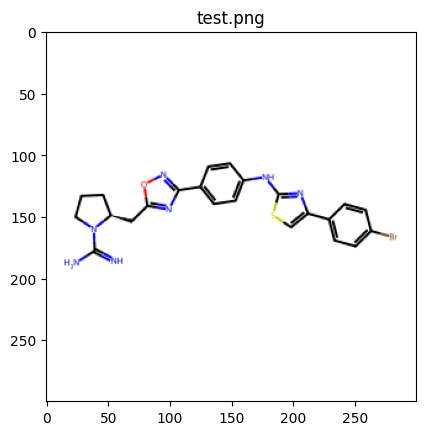

'/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/img/test.png'

In [67]:
convert_to_image('test', 'NC(=N)N1CCC[C@H]1Cc2onc(n2)c3ccc(Nc4nc(cs4)c5ccc(Br)cc5)cc3')

In [68]:
# sm_names = drug_df.sm_name.str.lower().replace(' ', '_').tolist()
sm_names = drug_df.sm_name.tolist()
sm_smiles = drug_df.SMILES.tolist()

In [69]:
ro5_descriptors = []
for sm_name, sm in list(zip(sm_names, sm_smiles)):
  ro5 = extract_ro5_descriptors(sm_name, sm)
  ro5_descriptors.append(ro5)

ro5_df = pd.DataFrame(ro5_descriptors)
ro5_df

,sm_name,MW,HBA,HBD,LogP,pass_ro5
0,Clotrimazole,344.845,2,0,5.37670,True
1,Mometasone Furoate,521.437,6,1,4.86920,True
2,Idelalisib,415.432,8,2,3.75430,True
3,Vandetanib,475.362,6,1,5.00420,True
4,Bosutinib,530.456,8,1,5.19038,False
...,...,...,...,...,...,...
141,CGM-097,659.271,8,0,6.58350,False
142,TGX 221,364.449,6,1,3.01262,True
143,Azacitidine,244.207,9,5,-3.16800,True
144,Atorvastatin,558.650,7,4,6.31360,False


In [70]:
ro5_path = f"{intermediate_path}/ro5_descriptors.csv"
ro5_df.to_csv(ro5_path, index=False)
print(f'Saved {ro5_df.shape[0]} small molecule descriptors in path:\n{ro5_path}')

Saved 146 small molecule descriptors in path:
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/ro5_descriptors.csv


In [71]:
ro5_path = f"{intermediate_path}/ro5_descriptors.csv"
ro5_df = pd.read_csv(ro5_path)
print(f'Read {ro5_df.shape[0]} small molecule descriptors from path:\n{ro5_path}')
ro5_df

Read 146 small molecule descriptors from path:
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/ro5_descriptors.csv


,sm_name,MW,HBA,HBD,LogP,pass_ro5
0,Clotrimazole,344.845,2,0,5.37670,True
1,Mometasone Furoate,521.437,6,1,4.86920,True
2,Idelalisib,415.432,8,2,3.75430,True
3,Vandetanib,475.362,6,1,5.00420,True
4,Bosutinib,530.456,8,1,5.19038,False
...,...,...,...,...,...,...
141,CGM-097,659.271,8,0,6.58350,False
142,TGX 221,364.449,6,1,3.01262,True
143,Azacitidine,244.207,9,5,-3.16800,True
144,Atorvastatin,558.650,7,4,6.31360,False


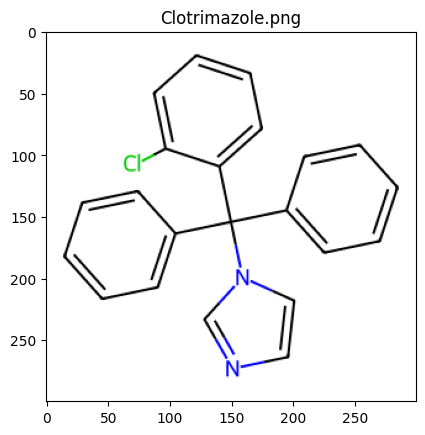

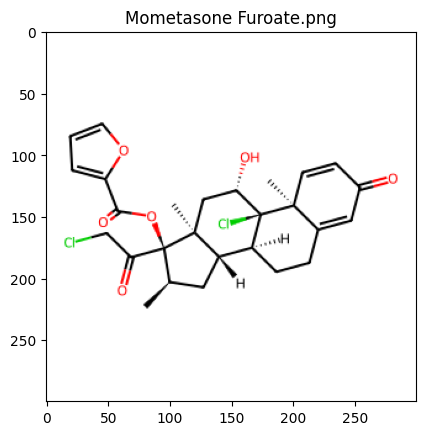

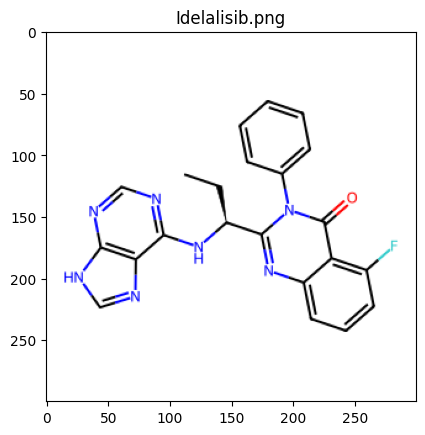

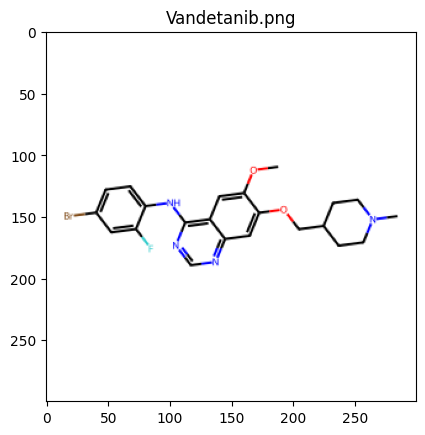

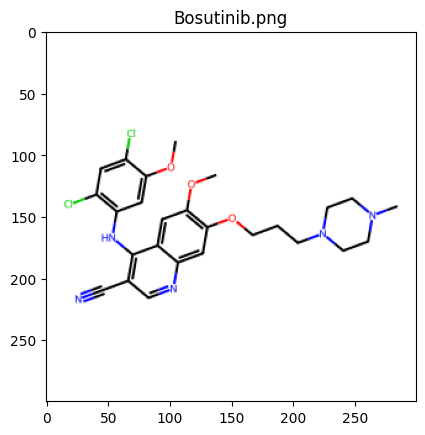

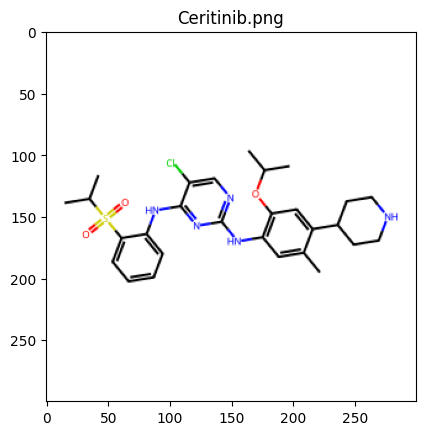

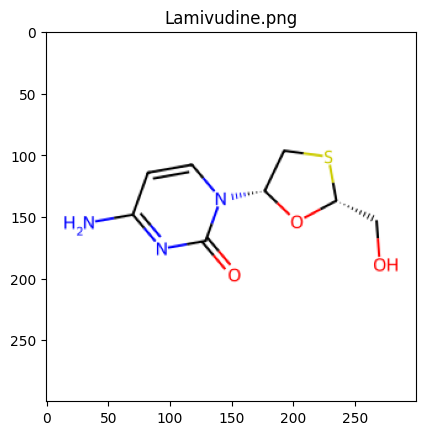

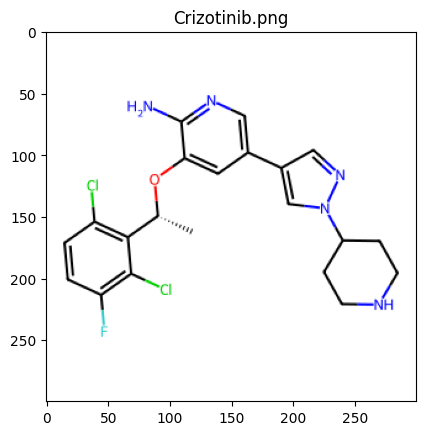

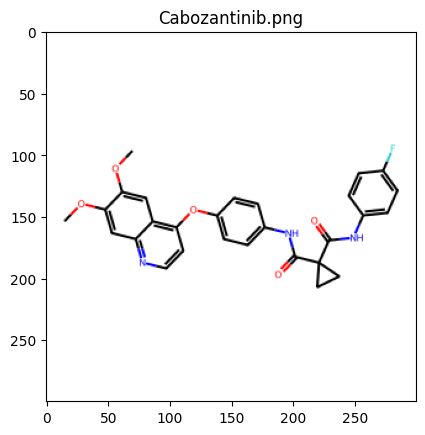

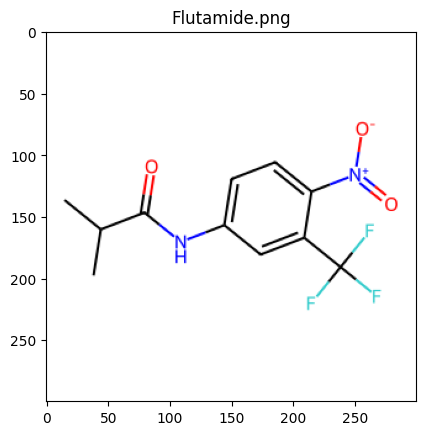

In [72]:
for sm_name, smile in list(zip(sm_names, sm_smiles))[:10]:
  convert_to_image(sm_name, smile)

In [73]:
# for sm_name, smile in list(zip(sm_names, sm_smiles)):
#   f = convert_to_mol(sm_name, smile)
#   print(f)

/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Clotrimazole.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Mometasone Furoate.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Idelalisib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Vandetanib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Bosutinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Ceritinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Lamivudine.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Crizotinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Cabozantinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Flutamide.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Dasatinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Selumetinib.mol
/conten

[06:55:20] UFFTYPER: Unrecognized charge state for atom: 15


/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/TIE2 Kinase Inhibitor.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/PD-0325901.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Isoniazid.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/GSK-1070916.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Masitinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Saracatinib.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/CC-401.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Decitabine.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Ketoconazole.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/HYDROXYUREA.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/BAY 61-3606.mol
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/mol/Navitoclax.mol
/cont

### Chem Fingerprints
* * *

In [74]:
from rdkit.Chem import MACCSkeys

smiles = "CC(=O)O"

mol = Chem.MolFromSmiles(smiles)

x = MACCSkeys.GenMACCSKeys(mol)
print(x.ToBitString())

00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000001000000000000001001011000100


In [75]:
print(tuple(x.GetOnBits()))

(123, 139, 154, 157, 159, 160, 164)


In [84]:
def extract_maccs_fingerprints(sm_name, smile):
    # print(sm_name, smile)
    mol = Chem.MolFromSmiles(smile)
    x = MACCSkeys.GenMACCSKeys(mol)
    return x.ToList()

fingerprints = []
for sm_name, smile in list(zip(sm_names, sm_smiles)):
  fp = extract_maccs_fingerprints(sm_name, smile)
  fingerprints.append(fp)

# fingerprints = np.asarray(fingerprints)
# fingerprints.shape

In [86]:
fingerprints_df = pd.DataFrame(data=zip(sm_names, fingerprints), columns=['sm_name', 'fingerprint'])
fingerprints_df.head()

,sm_name,fingerprint
0,Clotrimazole,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Mometasone Furoate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Idelalisib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Vandetanib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Bosutinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [87]:
fp_path = f"{intermediate_path}/fingerprints.csv"
fingerprints_df.to_csv(fp_path, index=False)
print(f'Saved {fingerprints_df.shape[0]} small molecule fingerprints in path:\n{fp_path}')

Saved 146 small molecule fingerprints in path:
/content/drive/MyDrive/as/study/biotec/kaggle/scp/intermediate/fingerprints.csv
